<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 003</h1>
<h1>Daily Case Fatality Rate</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

numpy      1.19.2
pandas     1.1.3
watermark  2.0.2
matplotlib 3.3.2
Sat Nov 21 2020 

CPython 3.8.5
IPython 7.19.0

compiler   : Clang 10.0.0 
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 979d2376df6ecb705f3bfeb24c3999cf686cef8b


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Global Cases

In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

In [5]:
world = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')
world.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
world = world.groupby('Country/Region').sum()

In [6]:
countries = pd.read_csv('data/countries.csv', index_col=1)

In [7]:
world = world.join(countries).groupby('Continent').sum().T

In [8]:
world.index = pd.to_datetime(world.index)

In [9]:
world = world.diff(1).rolling(7).mean()

Text(0.5, 0, 'Date')

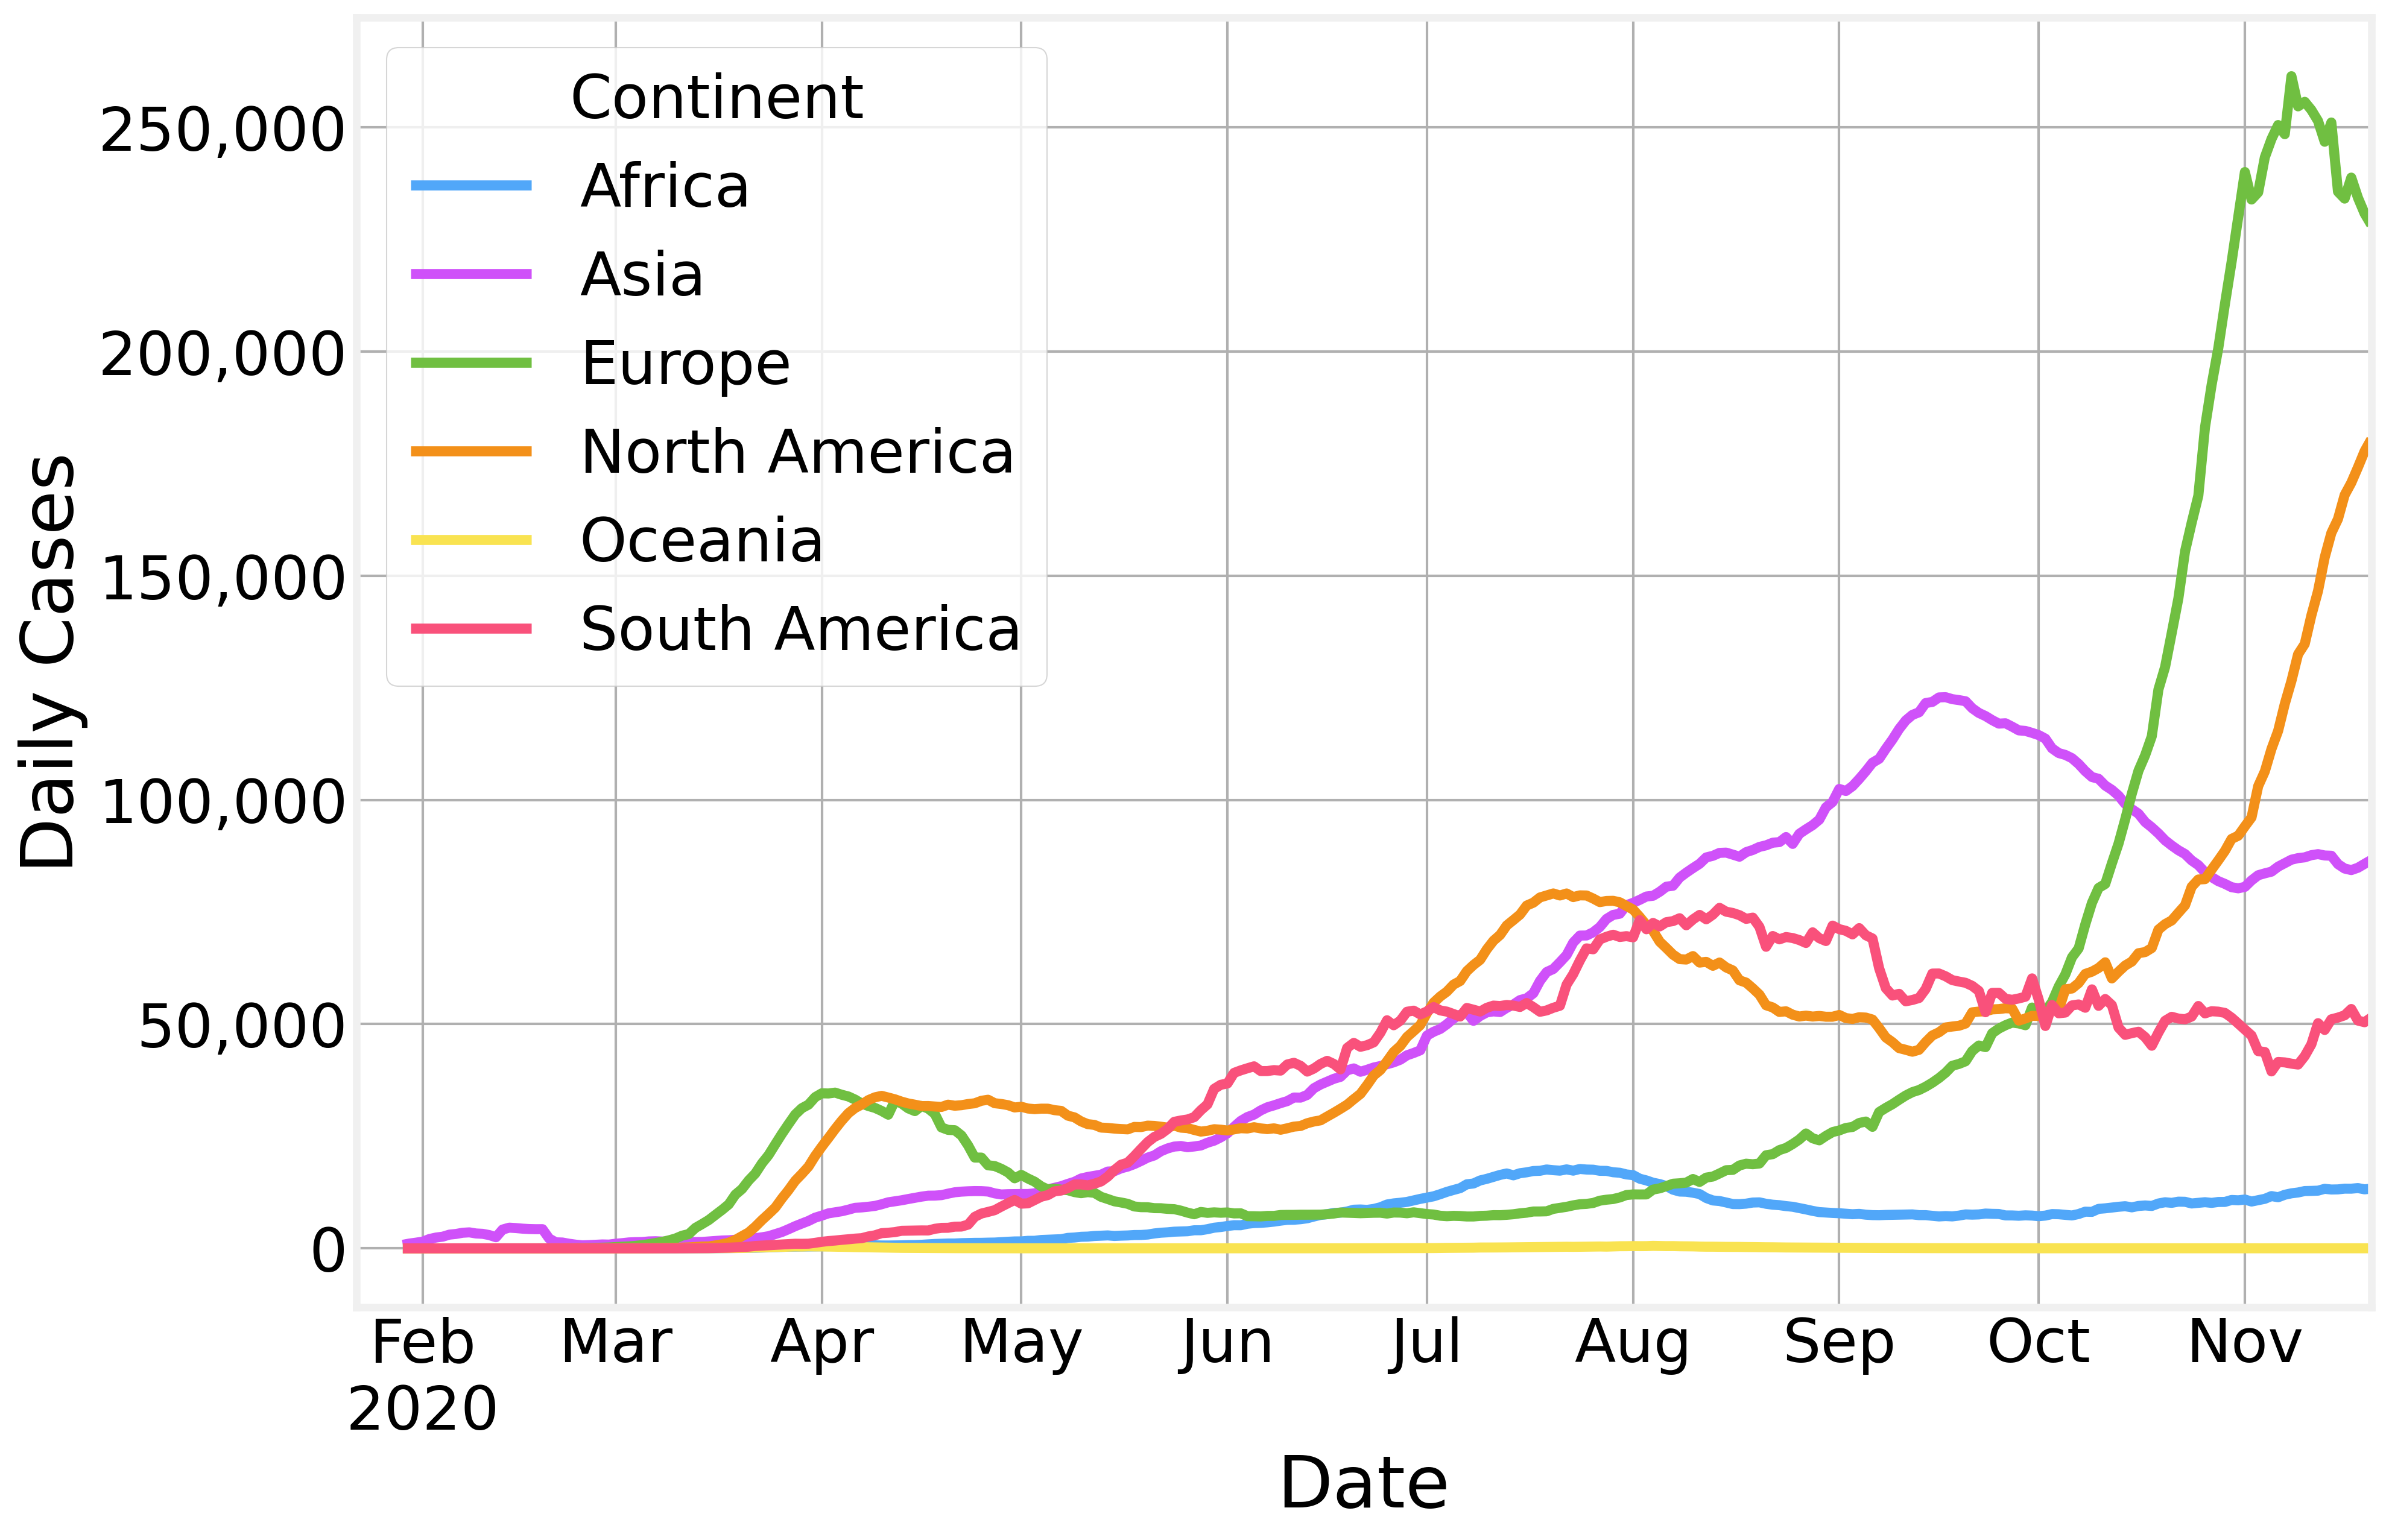

In [10]:
ax = world.plot()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Daily Cases')
ax.set_xlabel('Date')

# United States

In [11]:
confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_US.csv')
confirmed.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], inplace=True)
confirmed = confirmed.groupby('Province_State').sum().T
confirmed.index = pd.to_datetime(confirmed.index)
total_confirmed = confirmed.sum(axis=1).diff(1)
confirmed_mean = confirmed.diff(1).rolling(7).mean().fillna(0)


deaths = pd.read_csv(url + 'time_series_covid19_deaths_US.csv')
deaths.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'], inplace=True)
deaths = deaths.groupby('Province_State').sum().T
deaths.index = pd.to_datetime(deaths.index)
total_deaths = deaths.sum(axis=1).diff(1)
deaths_mean = deaths.diff(1).rolling(7).mean().fillna(0)

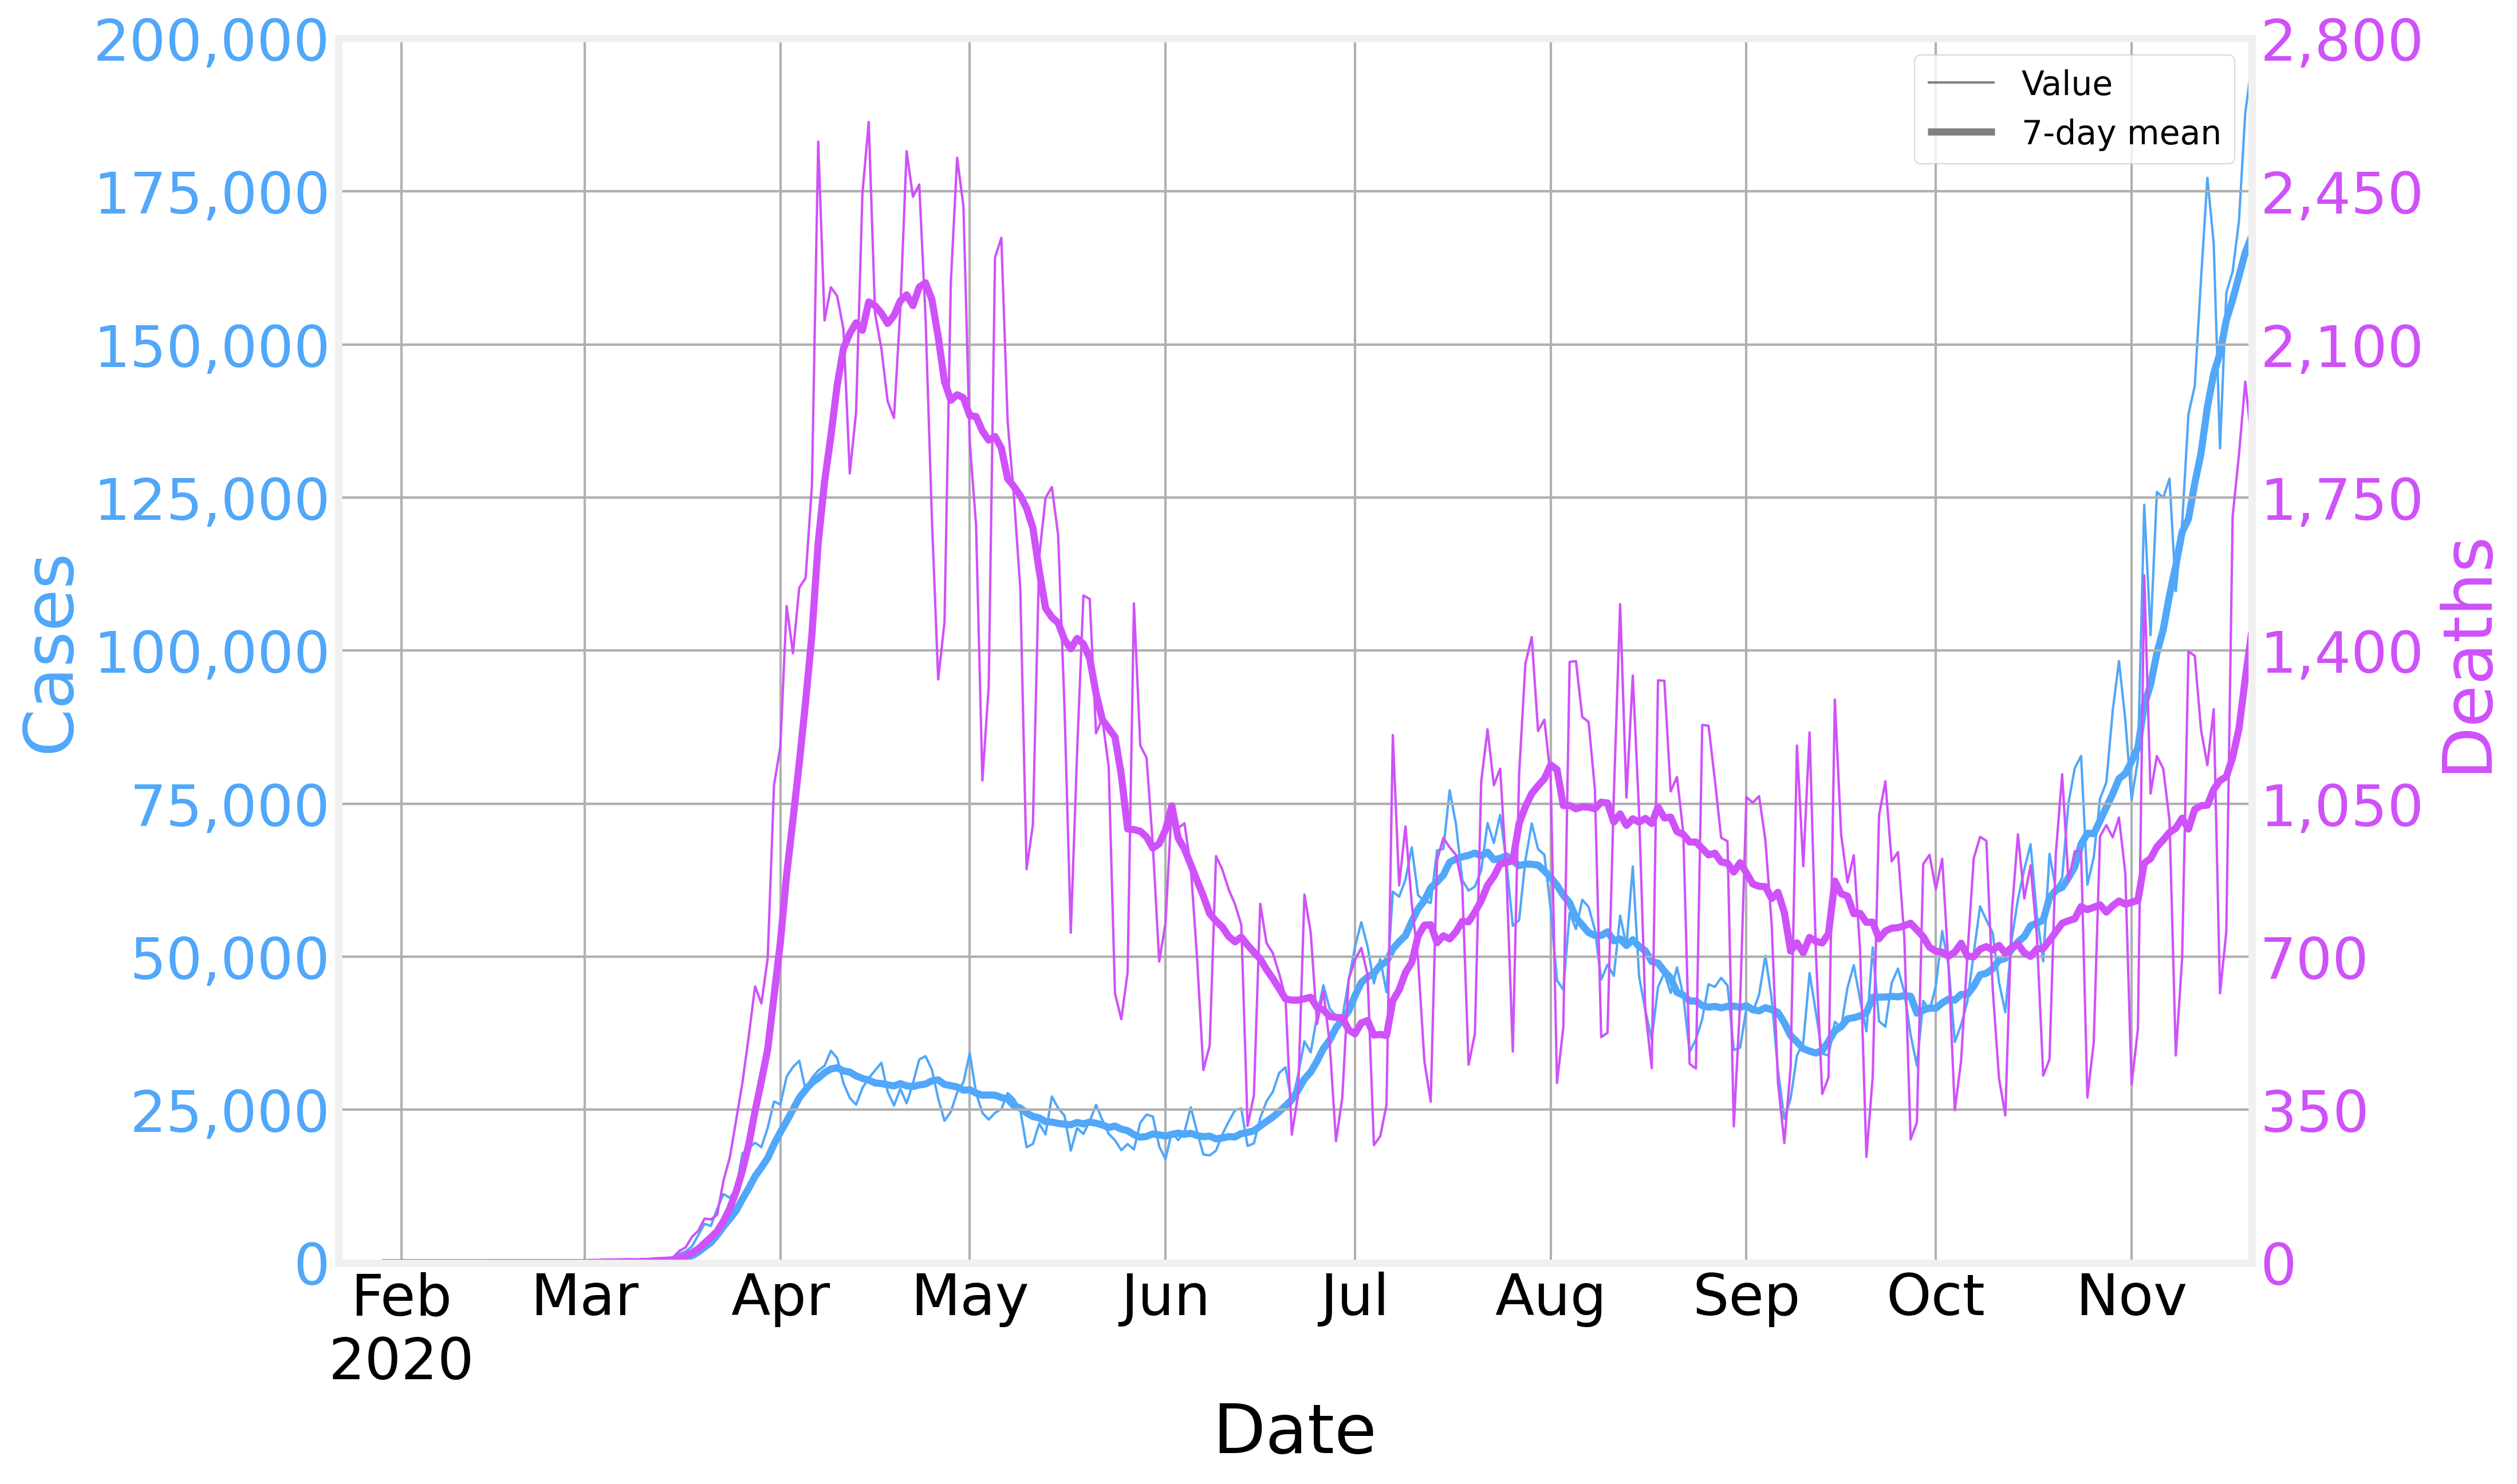

In [12]:
ax = total_confirmed.plot(lw=1)
total_confirmed.rolling(7).mean().plot(ax=ax, color=colors[0], lw=3)

ax2 = ax.twinx()
total_deaths.plot(ax=ax2, color=colors[1], lw=1)
total_deaths.rolling(7).mean().plot(ax=ax2, color=colors[1], lw=3)

ax.set_yticks(np.arange(0, 9)*25000)
ax.set_yticklabels(np.arange(0, 9)*25000, color=colors[0])
ax2.set_yticks(np.arange(0, 9)*350)
ax2.set_yticklabels(np.arange(0, 9)*350, color=colors[1])
ax.set_ylim(0, 8*25000)
ax2.set_ylim(0, 8*350)

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Cases', color=colors[0])
ax2.set_ylabel('Deaths', color=colors[1])
ax.set_xlabel('Date')

ax.legend(['Value', '7-day mean'], fontsize=14)
leg = ax.get_legend()
leg.legendHandles[0].set_color('gray')
leg.legendHandles[1].set_color('gray')

# Positive Tests

In [13]:
tests = pd.read_csv('https://covidtracking.com/data/download/national-history.csv', 
                    usecols=['date', 'positiveIncrease', 'totalTestResultsIncrease'],
                   parse_dates=['date'], index_col=0)

In [14]:
tests['positiveRate'] = tests['positiveIncrease']/tests['totalTestResultsIncrease']

Text(0, 0.5, 'Positive Tests (%)')

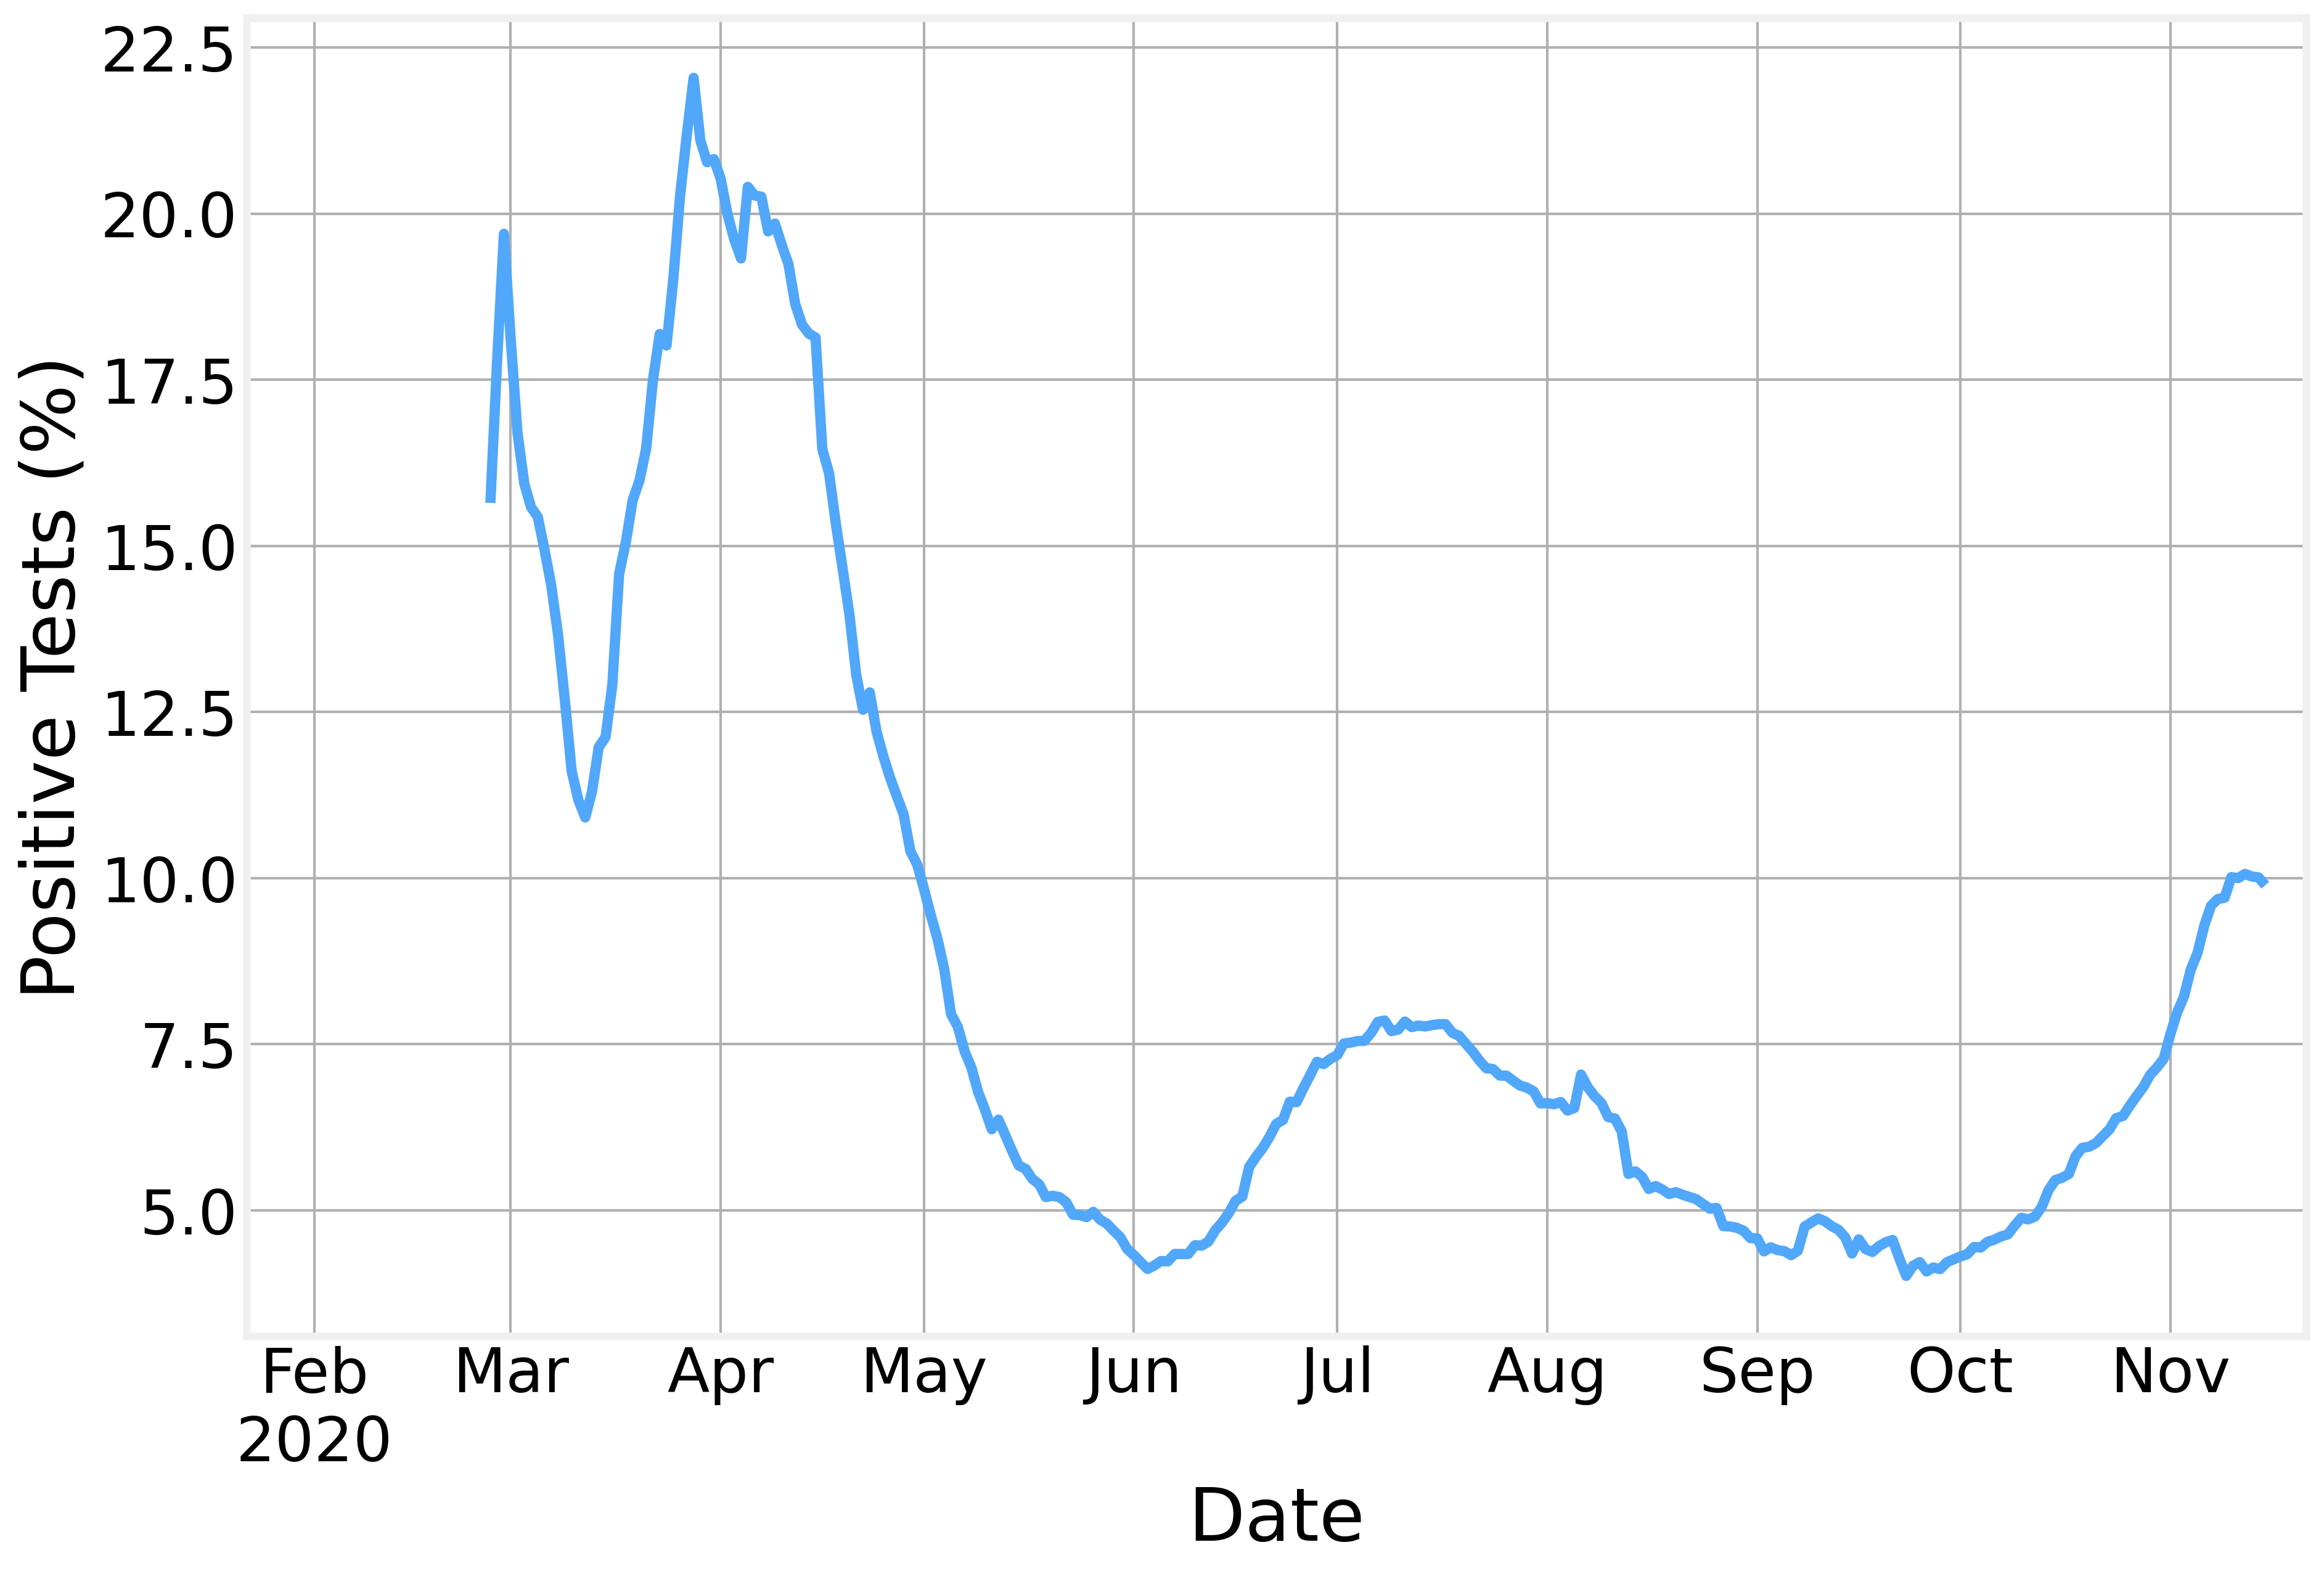

In [15]:
ax = (tests['positiveRate'].rolling(7).mean()*100).plot()
ax.set_xlabel('Date')
ax.set_ylabel('Positive Tests (%)')

# Death/Case Lag

In [16]:
states = pd.read_csv('data/states.csv')

In [17]:
confirmed_mean = confirmed_mean[states.name.values]['2020-04-01':]
deaths_mean = deaths_mean[states.name.values]['2020-04-01':]

In [18]:
total_confirmed = confirmed_mean.sum(axis=1)
total_deaths = deaths_mean.sum(axis=1)

In [19]:
correlations = {}

for state in deaths_mean.columns:
    correlations[state] = [deaths_mean[state].corr(confirmed_mean[state].shift(i)) for i in range(0, 41)]

In [20]:
correlations = pd.DataFrame.from_dict(correlations)
mean_correlations = correlations.mean(axis=1)

In [21]:
def plot_correlations(mean_correlations):
    max_lag = mean_correlations.idxmax()
    
    ax = mean_correlations.plot()
    ax.axvline(x=max_lag, color=colors[1], linestyle=':')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Correlation')
    yval = mean_correlations.mean()
    ax.text(x=max_lag+0.5, y=yval, s='Maximum')
    
    return max_lag

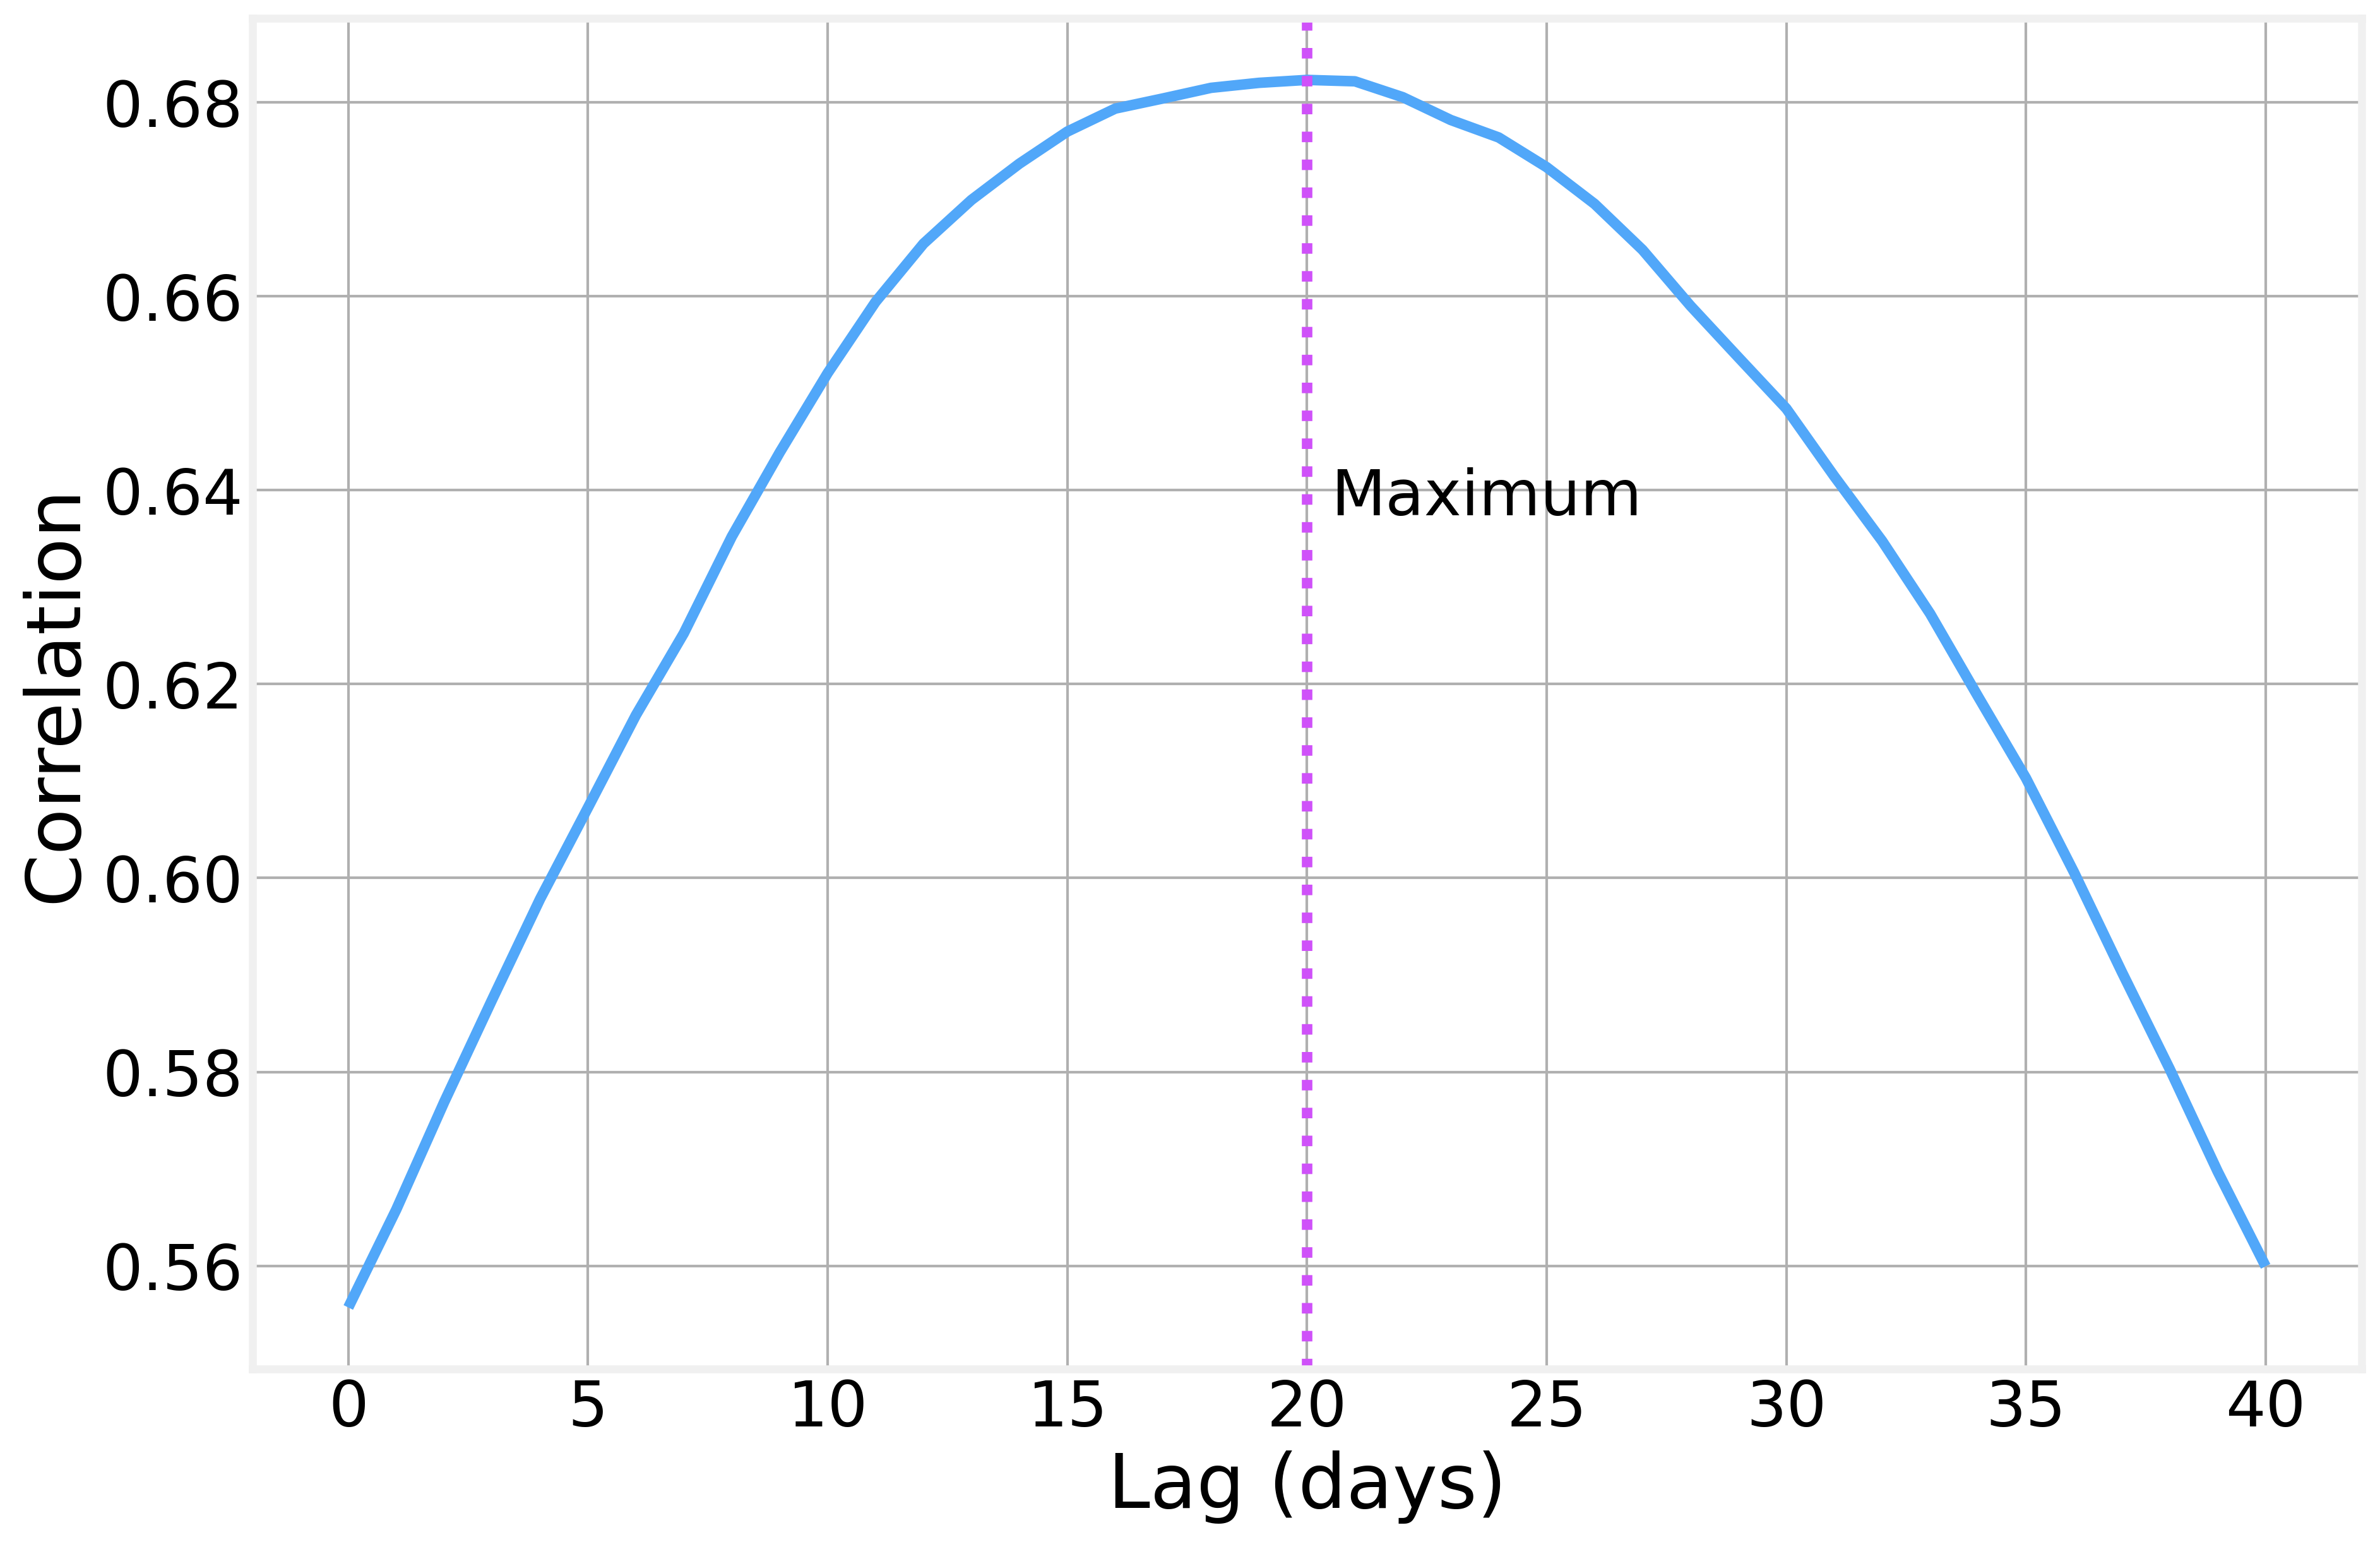

In [22]:
max_lag = plot_correlations(mean_correlations)

In [23]:
cfr = confirmed_mean.copy()

for state in confirmed_mean.columns:
    cfr[state] = deaths_mean[state]/confirmed_mean[state].shift(max_lag)

In [24]:
states.set_index('name', inplace=True)

In [25]:
mean_cfr = cfr.mean(axis=1)['2020-10-01':].mean()
std_cfr = cfr.mean(axis=1)['2020-10-01':].std()

Text(2020-05-02, 1.7165827241647282, 'mean=1.68%')

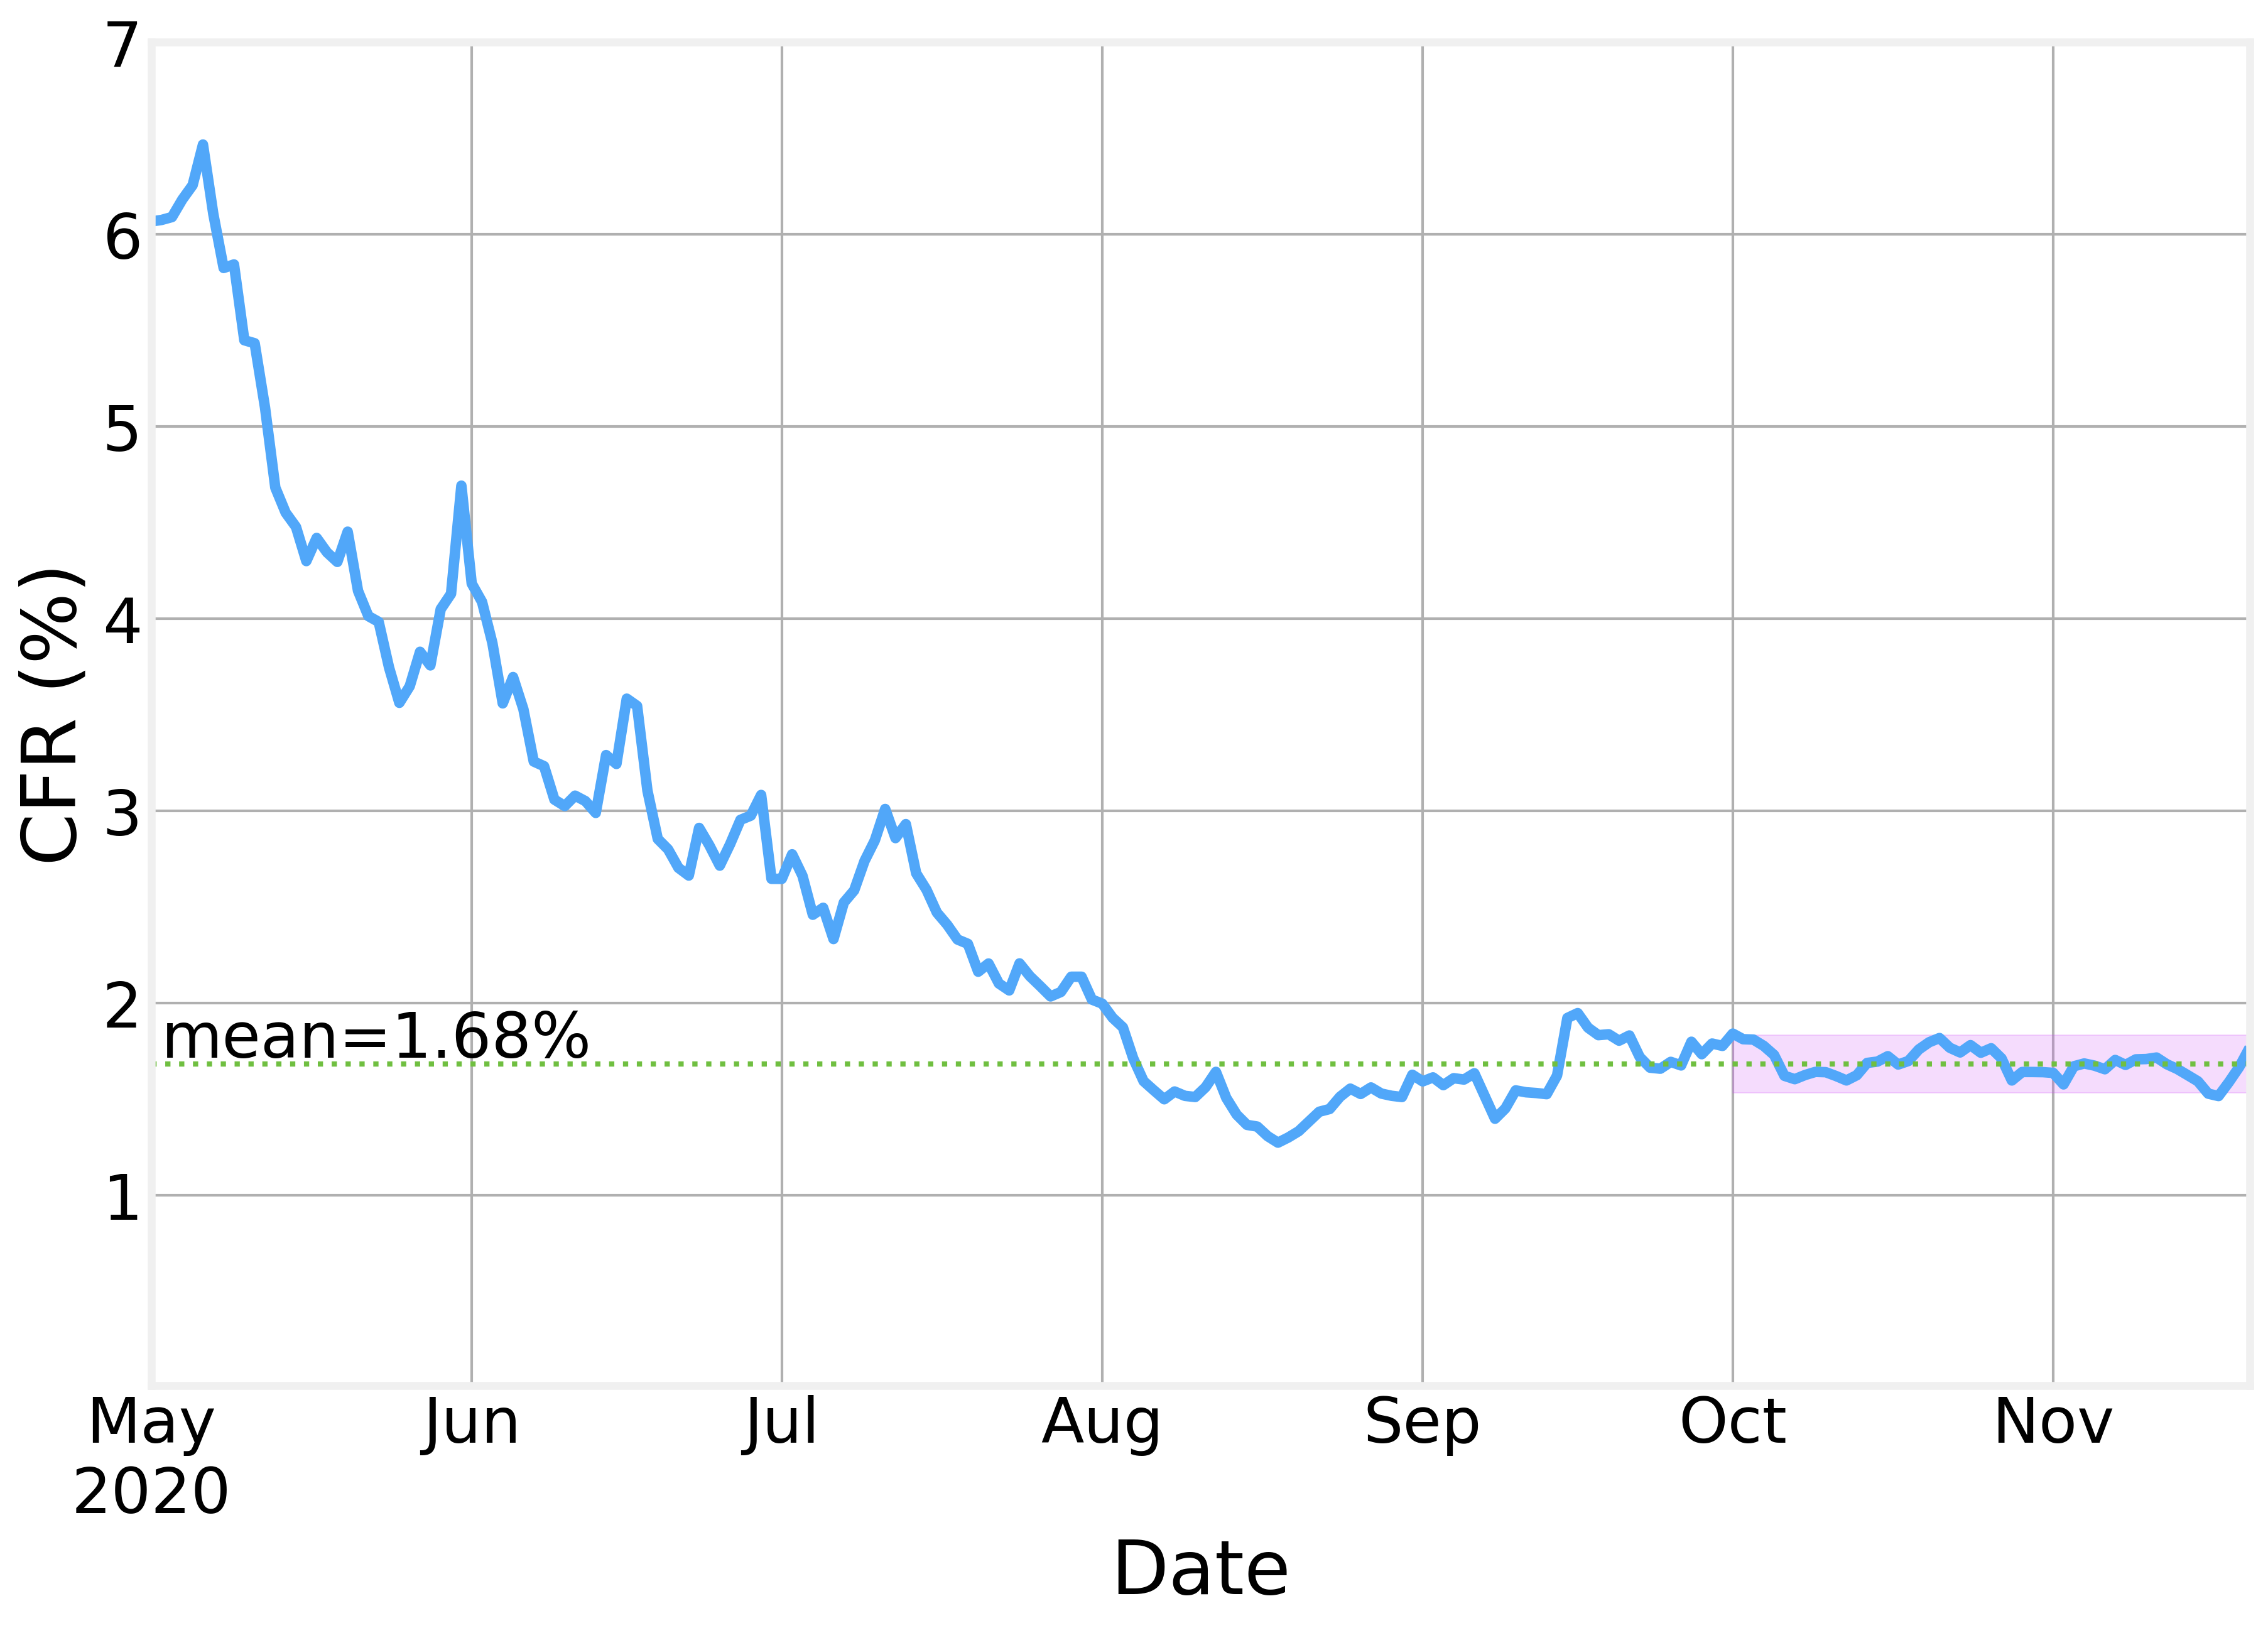

In [26]:
ax = (cfr.mean(axis=1)*100)['2020-05-01':].plot()
ax.set_ylim(0.01, 7)
xmin = cfr['2020-05-01':'2020-09-30'].shape[0]/cfr['2020-05-02':].shape[0]
ax.axhspan(ymin=(mean_cfr-2*std_cfr)*100, ymax=(mean_cfr+2*std_cfr)*100, xmin=xmin, color=colors[1], alpha=0.2)
ax.axhline(y=mean_cfr*100, color=colors[2], linestyle=':', lw=2)
ax.set_ylabel('CFR (%)')
ax.set_xlabel('Date')
ax.text(x='2020-05-02', y=mean_cfr*102, s='mean=%1.2f%%' % (mean_cfr*100))

## Case Fatality Rate by State

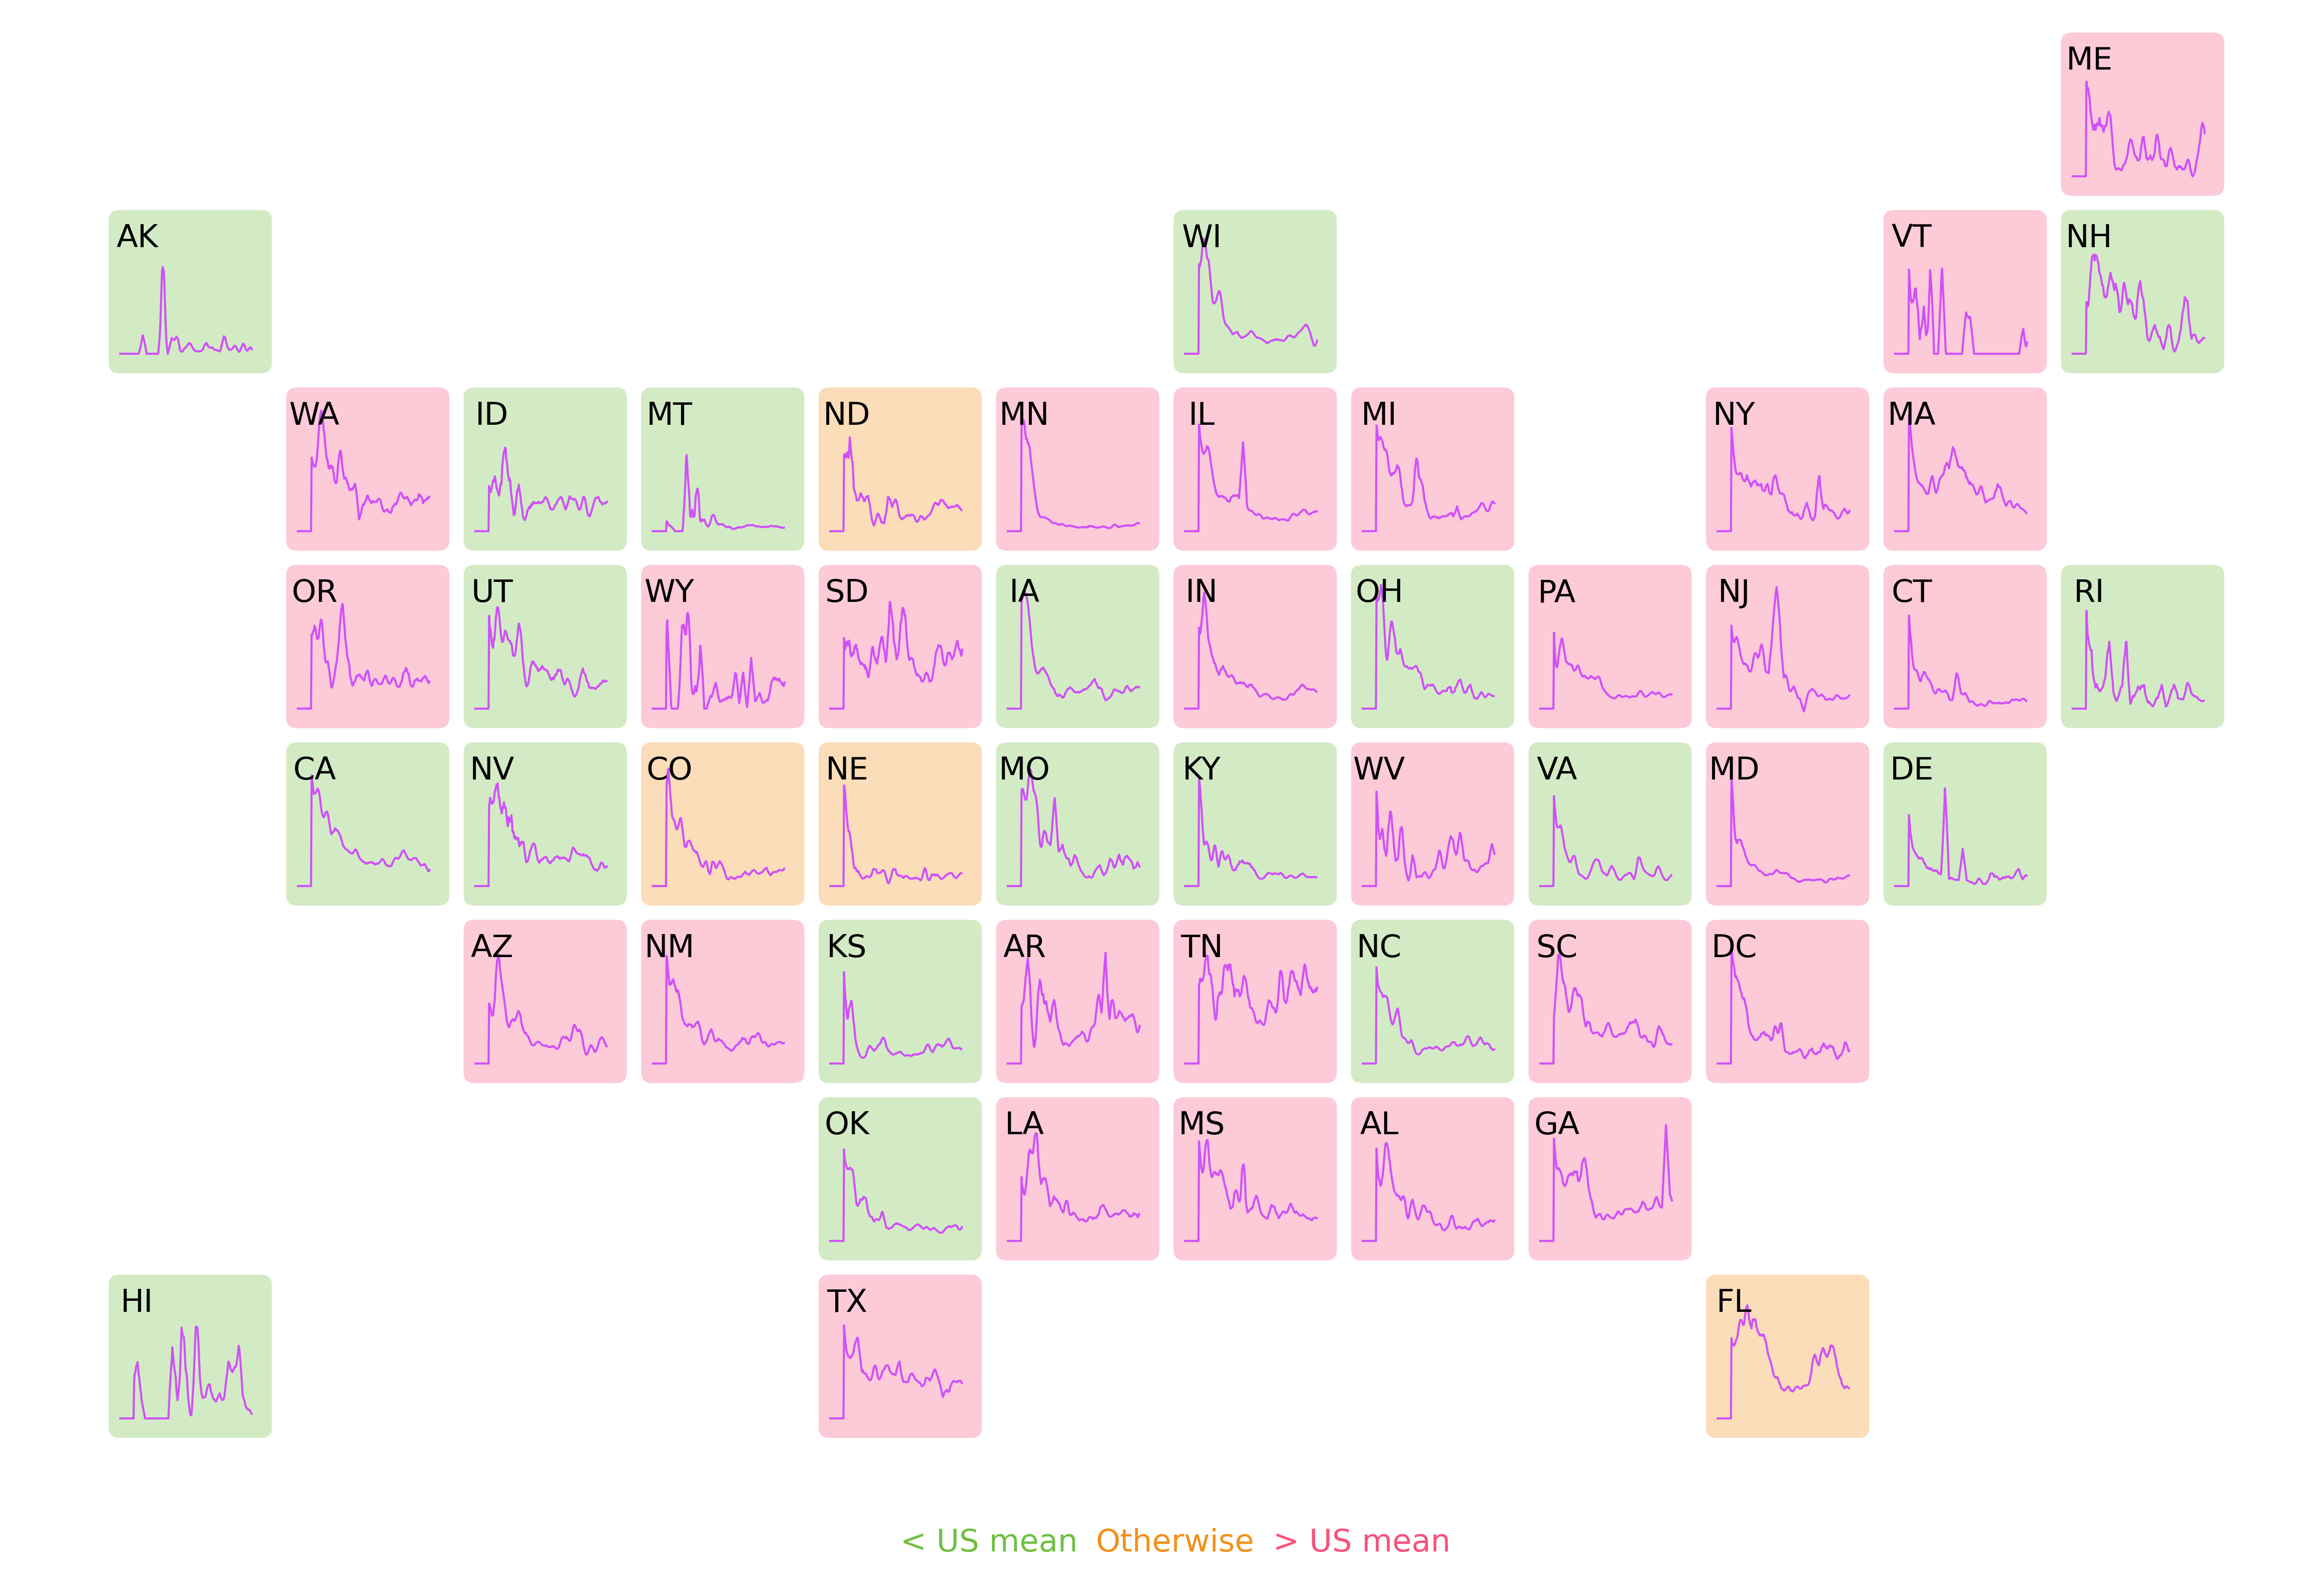

In [27]:
fig, ax = plt.subplots(1, figsize=(16, 22))
ax.set_aspect(1.)
ax.invert_yaxis()

patches = []
color_list = []

x = np.linspace(0., 0.75, cfr.shape[0])

for state in cfr.columns:
    daily = cfr[state]
    
    timeline = (daily.rolling(7).mean()/daily.max()).fillna(0).values
    color = colors[3]
    
    if daily[-1] > mean_cfr+std_cfr:
        color = colors[5]
    elif daily[-1] < mean_cfr-std_cfr:
        color = colors[2]
    
    fancybox = mpatches.FancyBboxPatch([states.x[state]-0.5, states.y[state]-0.5], 0.8, 0.8,
                                        boxstyle=mpatches.BoxStyle("Round", pad=0.06))
    patches.append(fancybox)
    color_list.append(color)
    
    ax.text(y=states.y[state]-0.4, x=states.x[state]-0.4, 
            s=states.loc[state, 'index'], horizontalalignment='center', verticalalignment='center', fontsize=15)
    ax.plot(states.x[state]+x-0.5, states.y[state]-timeline/1.4+0.25, lw=1, color=colors[1])

collection = PatchCollection(patches, facecolors=color_list, alpha=0.3)
ax.add_collection(collection)

ax.text(x=3.9, y=8, s='< US mean', color=colors[2], fontsize=15, ha='left')
ax.text(x=5, y=8, s='Otherwise', color=colors[3], fontsize=15, ha='left')
ax.text(x=6, y=8, s='> US mean', color=colors[5], fontsize=15, ha='left')

ax.axis('off')
fig.patch.set_facecolor('#FFFFFF')
fig.tight_layout()

## Predicted deaths

In [28]:
predicted = confirmed.sum(axis=1).diff(1).copy()*mean_cfr
predicted.index = predicted.index + pd.Timedelta('%s days' % max_lag)

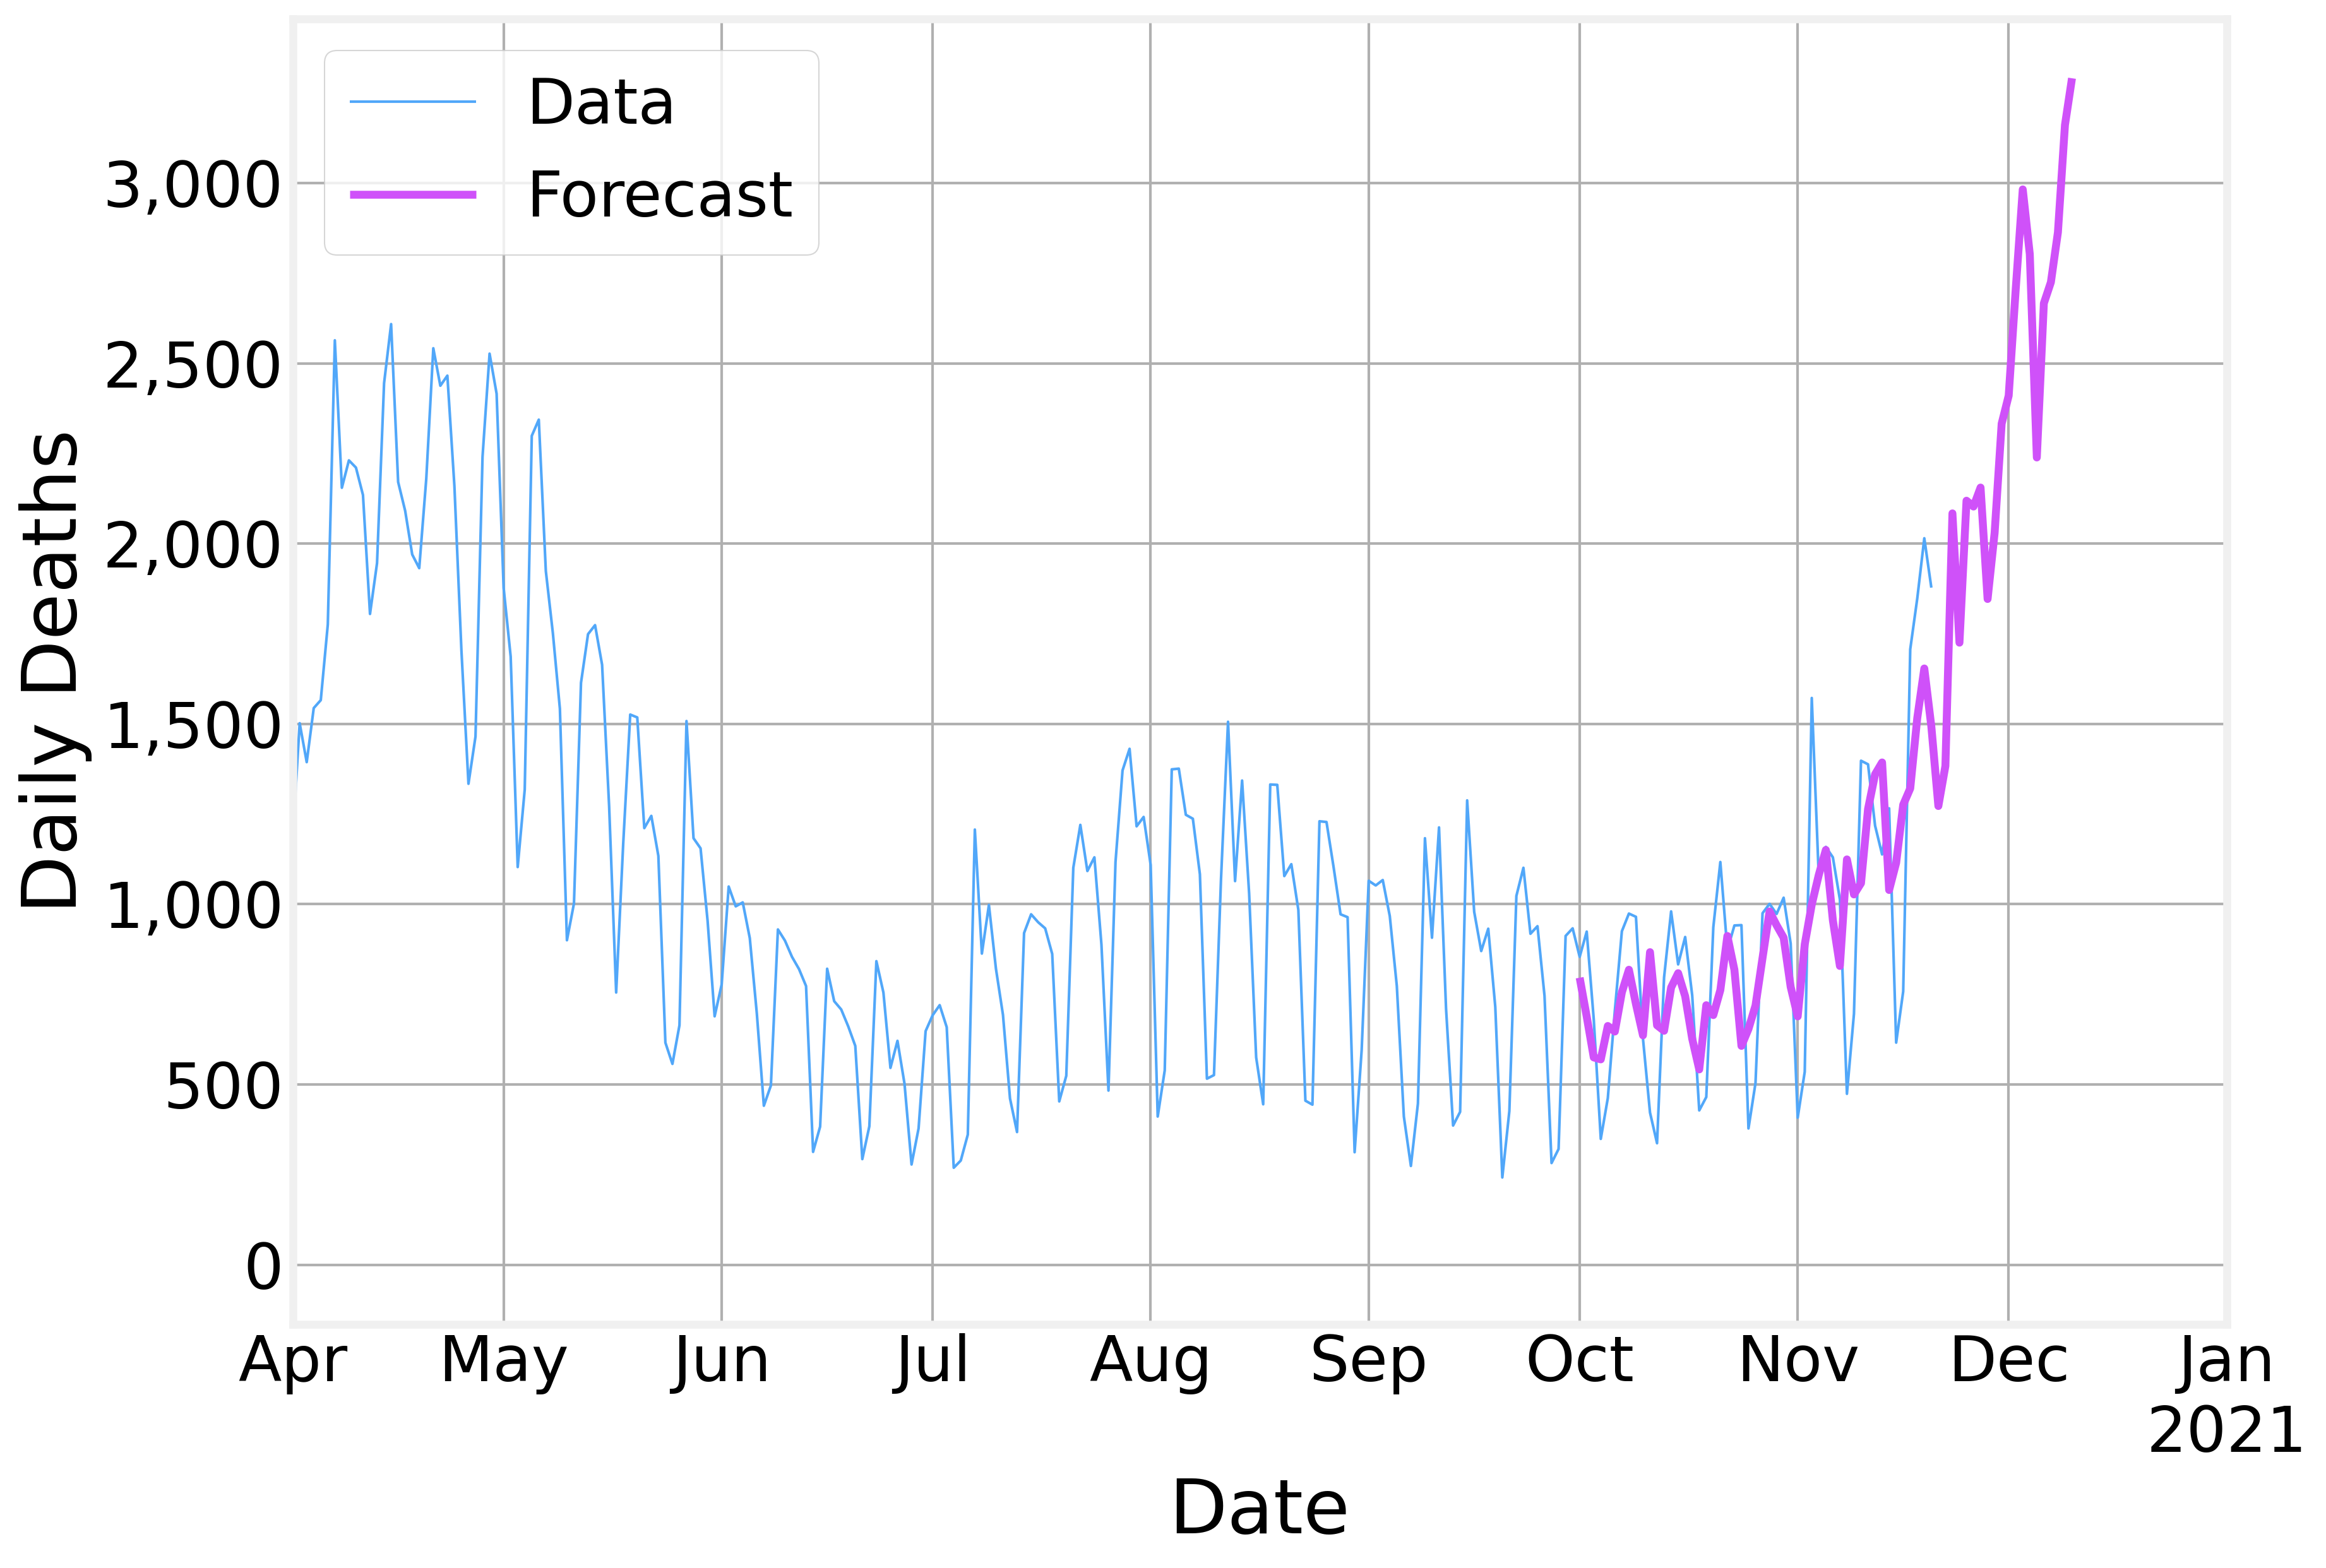

In [29]:
ax = deaths.sum(axis=1).diff(1).plot(lw=1)
predicted['2020-10-01':].plot(ax=ax, color=colors[1], lw=3)
ax.set_xlim('2020-04-01', '2021-01-01')
ax.legend(['Data', 'Forecast'])
ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Daily Deaths')
ax.set_xlabel('Date')

fig = plt.gcf()
fig.patch.set_facecolor('#FFFFFF')
fig.tight_layout()

Total expected deaths until the end of the next lag period.

In [30]:
deaths.sum(axis=1).iloc[-1]+predicted['2020-11-21':].sum()

301313.80977447657

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>